In [ ]:
    # fluorophore_colors = {
    #         'DAPI': (0,0,255),   # Blue
    #         'AF488': (0,255,0),  # Green
    #         'FITC': (0,255,0),  # Green
    #         'EGFP': (0,255,0),  # Green
    #         'Cy3': (255,255,0),  # yellow
    #         'Cy5': (255,0,0),  # Red
    #         'mCher': (255,0,0),# Red
    #         'Bright': (255,255,255),# White
    #         'mcher': (255, 0, 0),
    #         'af647': (255, 0, 0),
    #         'turfp': (255, 103, 0),   # reddish-orange
    #         # Add more fluorophores as needed
    #     }

In [1]:
import os
import numpy as np
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _composite_add_max(rgb, gray_u8, color_rgb):
    f = (gray_u8.astype(np.float32) / 255.0)[..., None]
    color = np.array(color_rgb, dtype=np.float32)[None, None, :]
    layer = (f * color).astype(np.uint8)
    return np.maximum(rgb, layer)

def _clip_and_norm(arr, perc=(1, 99)):
    """Clip intensities by percentiles and normalize to 0–1."""
    lo, hi = np.percentile(arr, perc)
    arr_clipped = np.clip(arr, lo, hi)
    if hi > lo:
        arr_norm = (arr_clipped - lo) / (hi - lo)
    else:
        arr_norm = np.zeros_like(arr)
    return arr_norm

def save_rgb_slices_from_nii(
    nii_path: str,
    out_dir: str,
    channels=(0,),
    colors=((0, 0, 255),),
    norm: str = "volume",          # "slice" or "volume"
    perc: tuple = (1, 99),         # percentile clip for normalization
    downscale: int = 2,
    file_prefix: str = None,
    z=None,
    show: bool = False,
    quality: int = 100
):
    """
    Save selected slice(s) from a NIfTI file as high-quality JPGs with percentile clipping.

    norm:  "volume" = global normalization
           "slice"  = per-slice normalization
    perc:  (low, high) percentiles for clipping (e.g., (1,99))
    """
    assert len(channels) == len(colors), "channels and colors must match"
    _ensure_dir(out_dir)

    img = sitk.ReadImage(nii_path)
    arr = sitk.GetArrayFromImage(img)
    n_comp = img.GetNumberOfComponentsPerPixel()

    # --- Normalize to (C,Z,Y,X)
    if n_comp > 1:
        Z, Y, X, C = arr.shape
        data = np.moveaxis(arr, -1, 0)
    else:
        if arr.ndim == 3:
            data = arr[np.newaxis, ...]
        elif arr.ndim == 4:
            data = arr
        else:
            raise ValueError(f"Unsupported NIfTI shape {arr.shape}")

    C, Z, Y, X = data.shape

    # --- Global normalization
    if norm == "volume":
        data = _clip_and_norm(data, perc=perc)

    # --- Slice selection
    if z is None:
        z_indices = range(Z)
    elif isinstance(z, int):
        z_indices = [z if z >= 0 else Z + z]
    else:
        z_indices = [zi if zi >= 0 else Z + zi for zi in z]

    base = file_prefix or os.path.splitext(os.path.basename(nii_path))[0]
    if base.endswith(".nii"):
        base = base[:-4]

    for zi in z_indices:
        rgb = np.zeros((Y, X, 3), dtype=np.uint8)
        for c, color in zip(channels, colors):
            gray = data[c, zi]
            if norm == "slice":
                gray = _clip_and_norm(gray, perc=perc)
            gray_u8 = (gray * 255).clip(0, 255).astype(np.uint8)
            rgb = _composite_add_max(rgb, gray_u8, color)

        if downscale > 1:
            h, w = rgb.shape[:2]
            rgb = cv2.resize(rgb, (w // downscale, h // downscale), interpolation=cv2.INTER_CUBIC)

        out_name = f"{base}_z{zi:04d}.jpg"
        out_path = os.path.join(out_dir, out_name)
        cv2.imwrite(out_path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
                    [cv2.IMWRITE_JPEG_QUALITY, quality,
                     cv2.IMWRITE_JPEG_PROGRESSIVE, 1])

        if show:
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb)
            plt.title(f"Slice {zi} / {Z-1} (perc={perc})")
            plt.axis("off")
            plt.show()

    print(f"[DONE] Saved {len(z_indices)} slice(s) to {out_dir} (norm={norm}, perc={perc}, quality={quality}).")





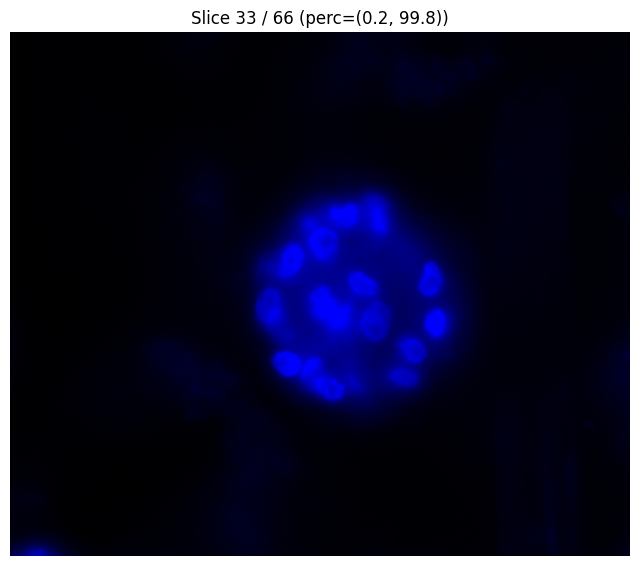

[DONE] Saved 1 slice(s) to images_out (norm=volume, perc=(0.2, 99.8), quality=100).


In [8]:


save_rgb_slices_from_nii(
    r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_f.nii.gz",
    out_dir="images_out",
    channels=(0,),
    colors=((0,0,255),),    # or multi-channel colors
    z=33,
    norm="volume",
    perc=(0.2, 99.8),
    downscale=2,
    quality=100,
    show=True
)


In [1]:
import os
import numpy as np
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# Small helpers
# -----------------------------
def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _clip_and_norm(arr, perc=(1, 99)):
    """Clip by percentiles and normalize to [0,1]. Accepts any shape."""
    lo, hi = np.percentile(arr, perc)
    arr_clipped = np.clip(arr, lo, hi)
    if hi > lo:
        return (arr_clipped - lo) / (hi - lo)
    return np.zeros_like(arr_clipped, dtype=np.float32)

def _as_CZYX(arr: np.ndarray, n_comp: int) -> np.ndarray:
    """
    Convert to (C,Z,Y,X).
    - 3D scalar -> (1,Z,Y,X)
    - 4D scalar -> (C,Z,Y,X) (assumed already)
    - 4D vector -> (Z,Y,X,Cv) -> (Cv,Z,Y,X)
    """
    if n_comp > 1:
        if arr.ndim != 4:
            raise ValueError(f"Unexpected vector image shape {arr.shape}")
        # (Z,Y,X,Cv) -> (Cv,Z,Y,X)
        return np.moveaxis(arr, -1, 0)
    else:
        if arr.ndim == 3:
            return arr[np.newaxis, ...]
        elif arr.ndim == 4:
            return arr
        else:
            raise ValueError(f"Unsupported image shape {arr.shape}")

def _resample_to_reference(moving_img: sitk.Image, reference_img: sitk.Image, interp="linear") -> sitk.Image:
    rf = sitk.ResampleImageFilter()
    rf.SetReferenceImage(reference_img)
    rf.SetInterpolator(sitk.sitkLinear if interp == "linear" else sitk.sitkNearestNeighbor)
    return rf.Execute(moving_img)

def _composite_blend(rgb, gray_u8, color_rgb, alpha=0.8, mode="screen"):
    """
    Blend a grayscale mask (0–255) colored as color_rgb into rgb using a mode.
    Modes: 'screen', 'add', 'over' (simple alpha-over).
    """
    f = (gray_u8.astype(np.float32) / 255.0)[..., None]     # (H,W,1) in [0,1]
    color = np.array(color_rgb, dtype=np.float32)[None, None, :]  # (1,1,3) in 0–255
    layer = f * color                                       # (H,W,3) 0–255

    base = rgb.astype(np.float32)
    if mode == "add":
        out = np.clip(base + alpha * layer, 0, 255)
    elif mode == "screen":
        a = base / 255.0
        b = (alpha * layer) / 255.0
        out = (1.0 - (1.0 - a) * (1.0 - b)) * 255.0
    else:  # 'over'
        out = (1 - alpha) * base + alpha * layer
    return out.astype(np.uint8)

# -----------------------------
# Main overlay utility
# -----------------------------
def overlay_two_niftis_slice(
    nii_path_a: str,
    nii_path_b: str,
    out_dir: str = "images_out",
    color_a=(0, 0, 255),          # first file color (blue)
    color_b=(255, 0, 0),          # second file color (red)
    chan_a: int = 0,
    chan_b: int = 0,
    z: int = 33,
    norm: str = "slice",          # 'slice' (more contrast) or 'volume'
    perc=(1, 99),
    clahe: bool = False,          # local contrast boost per channel
    clahe_clip: float = 2.0,
    clahe_tile: tuple = (8, 8),
    alpha_a: float = 0.9,         # blend strengths per channel
    alpha_b: float = 0.6,
    blend_mode: str = "screen",   # 'screen', 'add', or 'over'
    downscale: int = 2,
    resample_b_to_a: bool = True,
    save_png: bool = True,        # True = PNG (lossless), False = JPG
    quality: int = 100,
    show: bool = True,
    file_prefix: str = None
):
    _ensure_dir(out_dir)

    # Read images
    img_a = sitk.ReadImage(nii_path_a)
    img_b = sitk.ReadImage(nii_path_b)

    # Align B to A if requested
    if resample_b_to_a:
        img_b = _resample_to_reference(img_b, img_a, interp="linear")

    # To numpy
    arr_a = sitk.GetArrayFromImage(img_a)
    arr_b = sitk.GetArrayFromImage(img_b)

    data_a = _as_CZYX(arr_a, img_a.GetNumberOfComponentsPerPixel())
    data_b = _as_CZYX(arr_b, img_b.GetNumberOfComponentsPerPixel())

    # Check same grid
    _, Za, Ya, Xa = data_a.shape
    _, Zb, Yb, Xb = data_b.shape
    if (Za, Ya, Xa) != (Zb, Yb, Xb):
        raise ValueError(f"Grids differ: A={(Za,Ya,Xa)} vs B={(Zb,Yb,Xb)}. Set resample_b_to_a=True or fix inputs.")

    # Clamp z
    z = max(0, min(z, Za - 1))

    # Global normalization if requested
    if norm == "volume":
        data_a = _clip_and_norm(data_a, perc=perc)
        data_b = _clip_and_norm(data_b, perc=perc)

    # Prepare RGB canvas
    rgb = np.zeros((Ya, Xa, 3), dtype=np.uint8)

    # ---- Channel A
    ga = data_a[chan_a, z, ...]
    if norm == "slice":
        ga = _clip_and_norm(ga, perc=perc)
    a_u8 = (ga * 255).clip(0, 255).astype(np.uint8)
    if clahe:
        a_u8 = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_tile).apply(a_u8)
    rgb = _composite_blend(rgb, a_u8, color_a, alpha=alpha_a, mode=blend_mode)

    # ---- Channel B
    gb = data_b[chan_b, z, ...]
    if norm == "slice":
        gb = _clip_and_norm(gb, perc=perc)
    b_u8 = (gb * 255).clip(0, 255).astype(np.uint8)
    if clahe:
        b_u8 = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_tile).apply(b_u8)
    rgb = _composite_blend(rgb, b_u8, color_b, alpha=alpha_b, mode=blend_mode)

    # Downscale if requested
    if downscale and downscale > 1:
        h, w = rgb.shape[:2]
        rgb = cv2.resize(rgb, (w // downscale, h // downscale), interpolation=cv2.INTER_CUBIC)

    # Output name
    base_a = os.path.splitext(os.path.basename(nii_path_a))[0]
    base_b = os.path.splitext(os.path.basename(nii_path_b))[0]
    if base_a.endswith(".nii"): base_a = base_a[:-4]
    if base_b.endswith(".nii"): base_b = base_b[:-4]
    base = file_prefix or f"{base_a}__OVER__{base_b}"
    ext = ".png" if save_png else ".jpg"
    out_path = os.path.join(out_dir, f"{base}_z{z:04d}{ext}")

    # Save
    if save_png:
        cv2.imwrite(out_path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    else:
        cv2.imwrite(
            out_path,
            cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
            [cv2.IMWRITE_JPEG_QUALITY, quality, cv2.IMWRITE_JPEG_PROGRESSIVE, 1]
        )

    if show:
        plt.figure(figsize=(8, 8))
        plt.imshow(rgb)
        plt.title(f"Overlay z={z}  A→{color_a}, B→{color_b}  (norm={norm}, perc={perc}, mode={blend_mode})")
        plt.axis("off")
        plt.show()

    print(f"[DONE] Saved overlay: {out_path}")
    return out_path


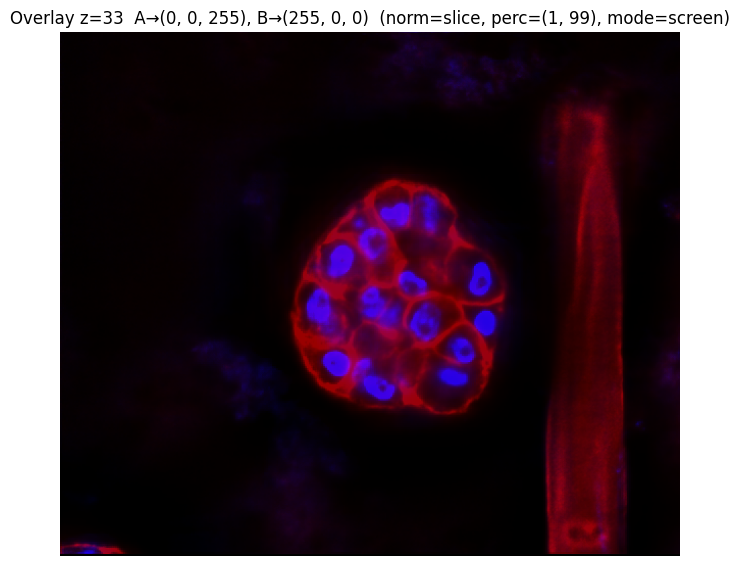

[DONE] Saved overlay: images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.png


'images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.png'

In [3]:

overlay_two_niftis_slice(
    nii_path_a=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_f.nii.gz",
    nii_path_b=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_sec.nii.gz",
    color_a=(0, 0, 255),     # first file → blue
    color_b=(255, 0, 0),     # second file → red
    z=33,
    norm="slice",            # stronger contrast per-slice
    perc=(1, 99),
    clahe=False,             # set True if you need more local contrast
    alpha_a=0.9,
    alpha_b=0.6,             # slightly lower so nuclei stay visible
    blend_mode="screen",
    downscale=2,
    resample_b_to_a=True,
    save_png=True,           # lossless for microscopy
    show=True
)


## BLUE BRIGTER

In [3]:
####

# NO BRIGHTER

import os
import numpy as np
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

# --- reuse your helpers (_ensure_dir, _composite_add_max, _clip_and_norm) ---
def _composite_add_max(rgb, gray_u8, color_rgb):
    f = (gray_u8.astype(np.float32) / 255.0)[..., None]
    color = np.array(color_rgb, dtype=np.float32)[None, None, :]
    layer = (f * color).astype(np.uint8)
    return np.maximum(rgb, layer)

def _clip_and_norm(arr, perc=(1, 99)):
    """Clip by percentiles and normalize to [0,1]. Accepts any shape."""
    lo, hi = np.percentile(arr, perc)
    arr_clipped = np.clip(arr, lo, hi)
    if hi > lo:
        return (arr_clipped - lo) / (hi - lo)
    return np.zeros_like(arr_clipped, dtype=np.float32)
    
def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _resample_to_reference(moving_img: sitk.Image, reference_img: sitk.Image, interp="linear") -> sitk.Image:
    rf = sitk.ResampleImageFilter()
    rf.SetReferenceImage(reference_img)
    rf.SetInterpolator(sitk.sitkLinear if interp == "linear" else sitk.sitkNearestNeighbor)
    return rf.Execute(moving_img)

def _as_CZYX(arr: np.ndarray, n_comp: int) -> np.ndarray:
    """
    Return array as (C,Z,Y,X).
    Supports:
      - 3D scalar -> (1,Z,Y,X)
      - 4D scalar -> (C,Z,Y,X) (already)
      - 4D vector (Z,Y,X,Cv) -> moveaxis to (Cv,Z,Y,X)
    """
    if n_comp > 1:
        # likely (Z,Y,X,Cv)
        if arr.ndim != 4:
            raise ValueError(f"Unexpected vector image shape {arr.shape}")
        Z, Y, X, Cv = arr.shape
        return np.moveaxis(arr, -1, 0)  # (Cv,Z,Y,X)
    else:
        if arr.ndim == 3:
            return arr[np.newaxis, ...]  # (1,Z,Y,X)
        elif arr.ndim == 4:
            return arr  # already (C,Z,Y,X)
        else:
            raise ValueError(f"Unsupported image shape {arr.shape}")

def overlay_two_niftis_slice(
    nii_path_a: str,
    nii_path_b: str,
    out_dir: str = "images_out",
    color_a=(0, 0, 255),        # blue
    color_b=(255, 0, 0),        # red
    chan_a: int = 0,            # which channel to use (if 4D)
    chan_b: int = 0,
    z: int = 33,
    norm: str = "volume",       # "volume" or "slice"
    perc=(1, 99),               # percentile clipping
    downscale: int = 2,
    resample_b_to_a: bool = True,
    quality: int = 100,
    show: bool = True,
    file_prefix: str = None
):
    """
    Overlay one slice (z) from two volumes with different colors and save a JPG.
    If grids differ, resamples volume B to match volume A (toggle via resample_b_to_a).
    """
    _ensure_dir(out_dir)

    # --- Read images
    img_a = sitk.ReadImage(nii_path_a)
    img_b = sitk.ReadImage(nii_path_b)

    # --- Optional resample B → A (to ensure same size/spacing/origin/direction)
    if resample_b_to_a:
        img_b = _resample_to_reference(img_b, img_a, interp="linear")

    # --- To numpy
    arr_a = sitk.GetArrayFromImage(img_a)  # (Z,Y,X) or (Z,Y,X,Cv)
    arr_b = sitk.GetArrayFromImage(img_b)

    data_a = _as_CZYX(arr_a, img_a.GetNumberOfComponentsPerPixel())
    data_b = _as_CZYX(arr_b, img_b.GetNumberOfComponentsPerPixel())

    # --- Sanity: same spatial dims
    _, Za, Ya, Xa = data_a.shape
    _, Zb, Yb, Xb = data_b.shape
    if (Za, Ya, Xa) != (Zb, Yb, Xb):
        raise ValueError(
            f"Volumes are on different grids after resampling setting. "
            f"A: {(Za,Ya,Xa)} vs B: {(Zb,Yb,Xb)}. "
            f"Try resample_b_to_a=True or inspect your inputs."
        )

    # Clamp/normalize z
    z = max(0, min(z, Za - 1))

    # --- Normalization (volume-level)
    if norm == "volume":
        data_a = _clip_and_norm(data_a, perc=perc)
        data_b = _clip_and_norm(data_b, perc=perc)

    # --- Compose RGB
    Y, X = Ya, Xa
    rgb = np.zeros((Y, X, 3), dtype=np.uint8)

    # A channel
    gray_a = data_a[chan_a, z, ...]
    if norm == "slice":
        gray_a = _clip_and_norm(gray_a, perc=perc)
    a_u8 = (gray_a * 255).clip(0, 255).astype(np.uint8)
    rgb = _composite_add_max(rgb, a_u8, color_a)

    # B channel
    gray_b = data_b[chan_b, z, ...]
    if norm == "slice":
        gray_b = _clip_and_norm(gray_b, perc=perc)
    b_u8 = (gray_b * 255).clip(0, 255).astype(np.uint8)
    rgb = _composite_add_max(rgb, b_u8, color_b)

    # --- Downscale (optional)
    if downscale and downscale > 1:
        h, w = rgb.shape[:2]
        rgb = cv2.resize(rgb, (w // downscale, h // downscale), interpolation=cv2.INTER_CUBIC)

    # --- Save
    base_a = os.path.splitext(os.path.basename(nii_path_a))[0]
    base_b = os.path.splitext(os.path.basename(nii_path_b))[0]
    if base_a.endswith(".nii"): base_a = base_a[:-4]
    if base_b.endswith(".nii"): base_b = base_b[:-4]

    base = file_prefix or f"{base_a}__OVER__{base_b}"
    out_name = f"{base}_z{z:04d}.jpg"
    out_path = os.path.join(out_dir, out_name)

    cv2.imwrite(
        out_path,
        cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
        [cv2.IMWRITE_JPEG_QUALITY, quality, cv2.IMWRITE_JPEG_PROGRESSIVE, 1]
    )

    if show:
        plt.figure(figsize=(8, 8))
        plt.imshow(rgb)
        plt.title(f"Overlay z={z}  A→{color_a}, B→{color_b}  (perc={perc}, norm={norm})")
        plt.axis("off")
        plt.show()

    print(f"[DONE] Saved overlay: {out_path}")
    return out_path



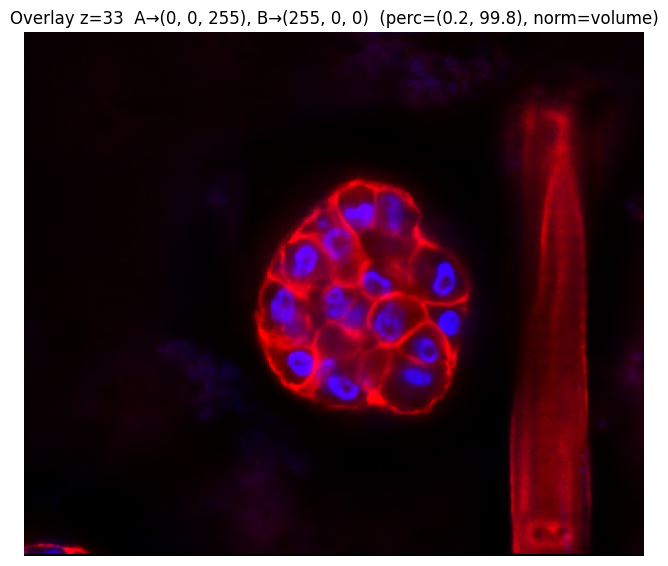

[DONE] Saved overlay: images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.jpg


'images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.jpg'

In [5]:
overlay_two_niftis_slice(
    nii_path_a=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_f.nii.gz",
    nii_path_b=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_sec.nii.gz",
    color_a=(0, 0, 255),        # first file → blue
    color_b=(255, 0, 0),        # second file → red
    z=33,
    norm="volume",              # or "slice" if you need per-slice equalization
    perc=(0.2, 99.8),           # matches what you were using
    downscale=2,
    resample_b_to_a=True,       # keep True unless you already know grids match
    quality=100,
    show=True
)
## SAME 